# Developing NEM Wrapper

Here i am developing step 005 NEMs script. This script is a simple wrapper around the NEMs package in order to allow us to run NEMs as apart of the pipeline. In order to simplify the code I am removing all unnecessary sections of code and methods. First version of this script will focus on using the NEM methods apart of the NEM bioconductor package.

## NEM Methods I Want to Add:
    - factor graph NEMs
    - probabilistic combination NEMs
    - boolean NEMs
    - linear effect models (possible we usually dont have combinatorial data)

In [3]:
step_005_nems = function(egene_mat_fp, cell_line, prep_method, nem_method, nems_dir, report_attached_egenes=FALSE) {
    # main function of the nems wrapper script
    
    mats = load_egene_mat(egene_mat_fp)
    nem_type = egene_mat_datatype(prep_method)
    nem_model = run_nems(mats, nem_method, nem_type)

    if (report_attached_egenes) {
        nem_model = attach_egenes(nem_model, egenes_mat)
    }

    model_fp = file.path(nems_dir, paste(cell_line, prep_method, nem_method, 'nem_models.Rds', sep="_"))
    
    saveRDS(nem_model, model_fp)
    return (nem_model)
}

modelling_bootstrap = function(egene_mat_fp, prep_method, nem_method) {
    # looping through all of the bootstraps generated egene matrix
    bootstrap_nems = list()
    bootstrap_egene_list = load_egene_mat(egene_mat_fp)
    
    for (boot_name in names(bootstrap_egene_list)) {
        egene_mat = bootstrap_egene_list[[boot_name]]
        
        egene_mat = load_egene_mat(egene_mat_fp)
        nem_type = egene_mat_datatype(prep_method)
        nem_model = run_nems(egene_mat, nem_method, nem_type)
        
        bootstrap_nems[boot_name] = nem_model
    }
    
    return (bootstrap_nems)
}

load_egene_mat = function(egene_mat_fp){
    # load the egene matrix or bootstrap list of egene matrix
    stopifnot(file.exists(egene_mat_fp))
    egene_mat = readRDS(egene_mat_fp)
    
    return (egene_mat)
}

egene_mat_datatype = function(prep_method){
    # based on how the E-Gene matrix was prepared will determine the inference method NEMs package needs to use.
    # for binarized matrices we need to mLL for log densities use CONTmLLBayers.
    
    if (prep_method == 'binary') {
        type = "mLL" 
    } else {
        type = "CONTmLLBayes"
    }
    
    return (type)
}

run_nems = function(mats, nem_method, type, nboot=1) {
    # running NEMs
    print (paste0("constructing network models using ", nem_method))
    
    contr = c(0.15,0.05)
    hyper = nem::set.default.parameters(colnames(mats$data), 
                               para=contr, 
                               type=type)
    
    b = nem::nem.bootstrap(mats$data,
        inference=nem_method,
        control=hyper, 
        verbose=F,
        nboot=nboot)
    
    return(b)
}

# pipeline
# do nem calculations
attach_egenes = function(nem_model, egenes) {
    # we are going to get $graph, an adjacency matrix and $mappos, a list of lists of egenes
    # and want to turn this into a single matrix

    m = as(nem_model$graph, "matrix")
    sgenes = rownames(m)
    egenes = unique(unlist(nem_model$mappos))
    genes = append(sgenes, egenes)
    
    bigger = matrix(0L, nrow = length(genes), ncol= length(genes))
    colnames(bigger) = genes
    rownames(bigger) = genes
    bigger[sgenes, sgenes] = m[sgenes, sgenes]
    
    for (sg in sgenes) {
        at = nem_model$mappos[[sg]]
        bigger[sg, at] = 1
        bigger[at, sg] = 1
    }
    
    nem_model$graph = bigger
    
    return(nem_model)
}

In [4]:
cell_line = 'MCF7'
bin_prep = 'binary'
pval_prep = 'pvalue'
nem_method = 'triples'
filter_method = 'logfc_aprior'
nems_dir = "../data/005_nems"
prepared_dir = "../data/004_prepared"

nem_method_compat = list("binary" = c("triples", "nem.greedy", "ModuleNetwork"),
                         "pvalue" = c("triples", "nem.greedy", "ModuleNetwork"))

bin_fdr_aprior_egene_mat_fp = file.path(prepared_dir, paste(cell_line, bin_prep, 'fdr_aprior', 'gene_mat.Rds', sep="_"))
pval_fdr_aprior_egene_mat_fp = file.path(prepared_dir, paste(cell_line, pval_prep, 'fdr_aprior', 'gene_mat.Rds', sep="_"))

bin_logfc_aprior_egene_mat_fp = file.path(prepared_dir, paste(cell_line, bin_prep, 'logfc_aprior', 'gene_mat.Rds', sep="_"))
pval_logfc_aprior_egene_mat_fp = file.path(prepared_dir, paste(cell_line, pval_prep, 'logfc_aprior', 'gene_mat.Rds', sep="_"))

bin_custom_egene_mat_fp = file.path(prepared_dir, paste(cell_line, bin_prep, 'custom', 'gene_mat.Rds', sep="_"))
pval_custom_egene_mat_fp = file.path(prepared_dir, paste(cell_line, pval_prep, 'custom', 'gene_mat.Rds', sep="_"))


In [5]:
# bin_fdr_aprior_model = step_005_nems(bin_fdr_aprior_egene_mat_fp, cell_line, bin_prep, nem_method, nems_dir)
# pval_fdr_aprior_model = step_005_nems(pval_fdr_aprior_egene_mat_fp, cell_line, pval_prep, nem_method, nems_dir)

# bin_logfc_aprior_model = step_005_nems(bin_logfc_aprior_egene_mat_fp, cell_line, bin_prep, nem_method, nems_dir)
# pval_logfc_aprior_model = step_005_nems(pval_logfc_aprior_egene_mat_fp, cell_line, pval_prep, nem_method, nems_dir)

bin_custom_model = step_005_nems(bin_custom_egene_mat_fp, cell_line, bin_prep, nem_method, nems_dir)
pval_custom_model = step_005_nems(pval_custom_egene_mat_fp, cell_line, pval_prep, nem_method, nems_dir)

[1] "constructing network models using triples"
--> parallel bootstrap:  no 
19 perturbed genes -> 969 triples to check (lambda =  0 )
19 perturbed genes -> 969 triples to check (lambda =  0 )
       SUMO3 NCOA3 SUMO1 TFAP2C CREBBP NRIP1 GRHL2 NR2F2 ZMIZ1 TRIM33 SUMO2
SUMO3      0     0     1      0      0     0     0     0     0      0     0
NCOA3      1     0     1      0      0     0     1     1     0      0     0
SUMO1      0     0     0      0      0     0     0     0     0      0     0
TFAP2C     1     1     1      0      1     1     1     1     1      1     1
CREBBP     1     1     1      1      0     1     1     1     1      1     1
NRIP1      1     1     1      1      1     0     1     1     1      1     1
GRHL2      1     0     1      0      0     0     0     0     0      0     0
NR2F2      0     0     0      0      0     0     0     0     0      0     0
ZMIZ1      1     1     1      1      1     1     1     1     0      1     1
TRIM33     1     1     1      1      1     1   

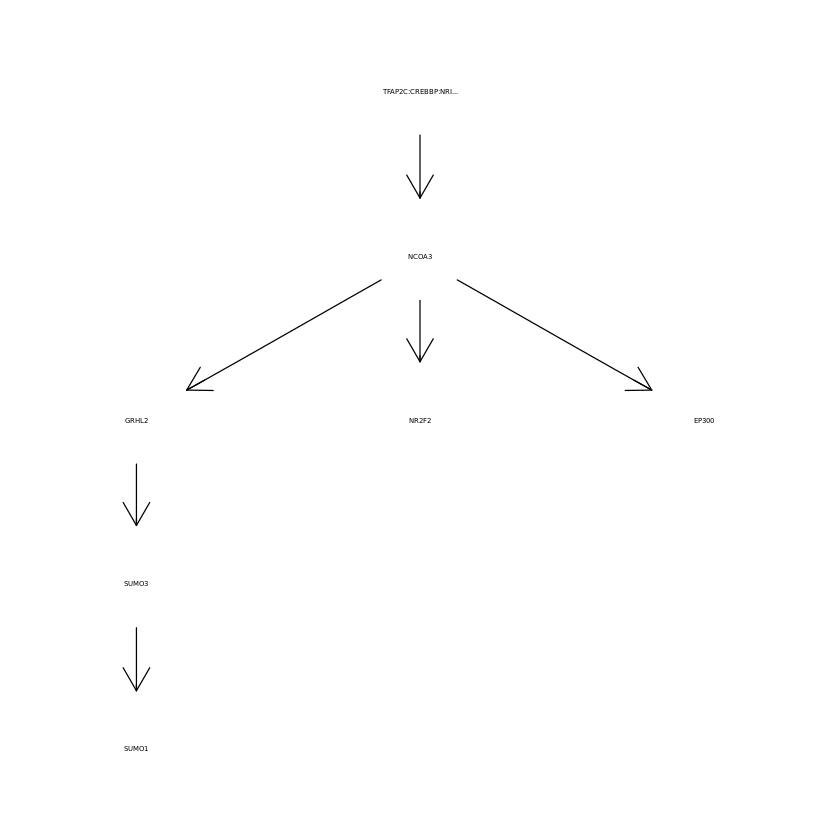

In [8]:
nem::plot.nem(bin_custom_model, transitiveReduction=TRUE)

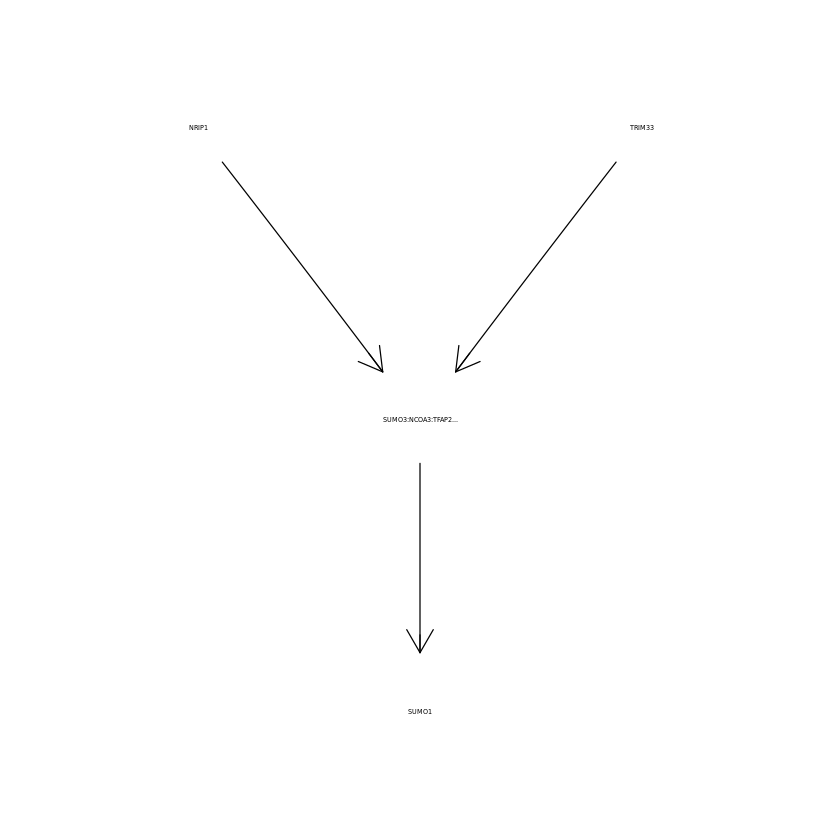

In [7]:
nem::plot.nem(pval_custom_model, transitiveReduction=TRUE)

In [8]:
?nem::plot.nem

plot.nem {nem},R Documentation
x,nem object to plot
what,"(i), ""graph"", (ii) ""mLL"" = likelihood distribution, (iii) ""pos"" = posterior position of effected genes"
remove.singletons,remove unconnected nodes from the graph plot
PDF,output as PDF-file
filename,filename of PDF-file
thresh,"if x has a real valued adjacency matrix (weight matrix), don't plot edges with |weight| <= thresh"
transitiveReduction,plot a transitively reduced graph
plot.probs,"plot edge weights/probabilities. If regulation directions have been inferred (see infer.edge.type), upregulated edges are drawn red and downregulated edges blue. Edges, were no clear direction could be inferred, are drawn in black."
SCC,plot the strongly connected components graph
D,Visualize the nested subset structure of the dataset via plotEffects along with the graph and show the linking of E-genes to S-genes in the dataset. Should only be used for small networks. Default: Just plot the graph
